# Part A: Using Numpy

# Importing packages

In [3]:
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
import sys
from keras.datasets import mnist
from matplotlib import pyplot
%matplotlib inline

In [4]:
! pip install -q scikit-plot

# Loading MNIST Data

In [5]:
(X_train, y_train), (x_test, y_test) = mnist.load_data()

# Augment training data

### Training data (6000) images are augmented by adding noise, applying sheer and zooming 

In [6]:
def augment_data(dataset, dataset_labels, augementation_factor=1, use_noise=True, use_random_shear=True, use_random_shift=True, use_scaling=True):
	augmented_image = []
	augmented_image_labels = []

	for num in range (0, dataset.shape[0]):

		for i in range(0, augementation_factor):
			# original image:
			

			transform_image=dataset[num]
			if use_noise:

				transform_image=iaa.AdditiveGaussianNoise(10,20).augment_image(transform_image)


			if use_random_shear:
				transform_image=iaa.Affine(shear=(0,40)).augment_image(transform_image)

			if use_scaling:
				transform_image=iaa.Affine(scale={"x": (1.5, 1.0), "y": (1.5, 1.0)}).augment_image(transform_image)
			augmented_image_labels.append(dataset_labels[num])
			augmented_image.append(transform_image)
	return np.array(augmented_image), np.array(augmented_image_labels)
# augment_data function is called to apply the changes to training data

X_train_aug,y_train_aug=augment_data(X_train,y_train,1,True,True,True,True)

# Visualize before and after data augmentation

Before Augmentation


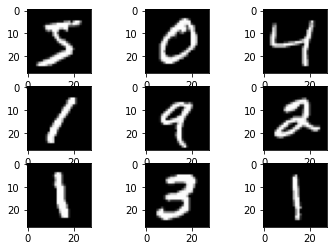

After Augmentation


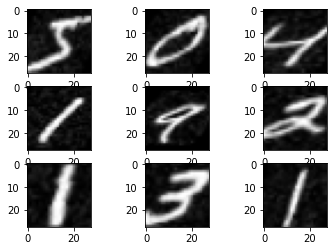

In [7]:
print("Before Augmentation")
for i in range(0, 9):
		 
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))
	# show the plot

pyplot.show()

print("After Augmentation")
for i in range(0, 9):
		
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(X_train_aug[i], cmap=pyplot.get_cmap('gray'))
	# show the plot

pyplot.show()

# Dropout Function based on percentage

In [8]:
def dropout_mask_create(num_create,percent):
  drop_count=round((num_create/100)*percent)
  index_drop=np.random.permutation(num_create)[:drop_count]
  
  dropout_mask=np.ones(num_create)
  for i in index_drop:
    dropout_mask[i]=0
  return dropout_mask

# Resizing and one_hot_encoding of labels 

In [9]:
x_train=X_train_aug
images, labels = (x_train[0:x_train.shape[0]].reshape(x_train.shape[0],28*28) / 255, y_train[0:x_train.shape[0]])
test_images = x_test.reshape(len(x_test),28*28) / 255
test_labels = np.zeros((len(y_test),10))
one_hot_labels = np.zeros((len(labels),10))
for i,l in enumerate(labels):
    one_hot_labels[i][l] = 1
labels = one_hot_labels

y_test_true_labels=[None] * y_test.size
y_test_pred_labels=[None] * y_test.size
for i,l in enumerate(y_test):
    test_labels[i][l] = 1



# Values set after multiple trials on the network configuration parameters

### Learning rate is set to 0.001

### Number of iterations is set to 25


###Hidden Layer units
Layer 2 : 128 units <br>
Layer 3 : 100 units <br>
Layer 4 : 50 units <br>


###Mini Batch Size is set to 8

In [10]:
alpha, iterations, hidden_size1,hidden_size2,hidden_size3,pixels_per_image, num_labels, batch_size = (0.001, 17, 128,100,50, 784, 10,8)


# Relu and its derivative

In [11]:
relu = lambda x:(x>=0) * x # returns x if x > 0, return 0 otherwise
relu2deriv = lambda x: x>=0 # returns 1 for input > 0, return 0 otherwise

# Weight Initialization specifically customized for relu activation functions

In [12]:
from math import *
np.random.seed(1)
weights_0_1 = 0.2*np.random.random((pixels_per_image,hidden_size1)) * sqrt(2.0 / pixels_per_image)
weights_1_2 = 0.2*np.random.random((hidden_size1,hidden_size2)) * sqrt(2.0 / hidden_size1)
weights_2_3 = 0.2*np.random.random((hidden_size2,hidden_size3)) * sqrt(2.0 / hidden_size2)
weights_3_4 = 0.2*np.random.random((hidden_size3,num_labels)) * sqrt(2.0 / hidden_size3)

# Training and Testing in mini batch

In [13]:
for j in range(iterations):
    error, correct_cnt = (0.0, 0)
    # Forward Propagation in mini batch of 8
    for i in range(int(len(images) / batch_size)):
        batch_start, batch_end = ((i * batch_size),((i+1)*batch_size))
        layer_0 = images[batch_start:batch_end]
        layer_1 = relu(np.dot(layer_0,weights_0_1))
        dropout_mask=[]
    #Adding dropout of 20 percentage
        for i in range(layer_1.shape[0]):
          dropout_mask.append(dropout_mask_create(layer_1.shape[1],20))
        layer_1 *= dropout_mask
        layer_2 = relu(np.dot(layer_1,weights_1_2))


        layer_3 = relu(np.dot(layer_2,weights_2_3))
        dropout_mask2=[]
    #Adding dropout of 5 percentage
        for i in range(layer_3.shape[0]):
          dropout_mask2.append(dropout_mask_create(layer_3.shape[1],5))
        layer_3 *= dropout_mask2
        layer_4 = np.dot(layer_3,weights_3_4)

        error += np.sum((labels[batch_start:batch_end] - layer_4) ** 2)
        #Backward Propagation in mini batch of 8
        for k in range(batch_size):
            correct_cnt += int(np.argmax(layer_4[k:k+1]) == np.argmax(labels[batch_start+k:batch_start+k+1]))
            layer_4_delta = (labels[batch_start:batch_end] - layer_4)/batch_size
            layer_3_delta = layer_4_delta.dot(weights_3_4.T)* relu2deriv(layer_3)
            layer_3_delta *= dropout_mask2
            layer_2_delta = layer_3_delta.dot(weights_2_3.T)* relu2deriv(layer_2)

            layer_1_delta = layer_2_delta.dot(weights_1_2.T)* relu2deriv(layer_1)
            layer_1_delta *= dropout_mask
            weights_3_4 += alpha * layer_3.T.dot(layer_4_delta)
            weights_2_3 += alpha * layer_2.T.dot(layer_3_delta)                           
            weights_1_2 += alpha * layer_1.T.dot(layer_2_delta)
            weights_0_1 += alpha * layer_0.T.dot(layer_1_delta)  
    if(j >=0):
        test_error = 0.0
        test_correct_cnt = 0
        # Testing for each iteration
        for i in range(len(test_images)):


            layer_0 = test_images[i:i+1]
            layer_1 = relu(np.dot(layer_0,weights_0_1))
            layer_2 = relu(np.dot(layer_1,weights_1_2))
            layer_3 = relu(np.dot(layer_2,weights_2_3))
            layer_4 = np.dot(layer_3,weights_3_4)
            test_error += np.sum((test_labels[i:i+1] - layer_4) ** 2)
            y_test_pred_labels[i]=np.argmax(layer_4)
            y_test_true_labels[i]=np.argmax(test_labels[i:i+1])
            test_correct_cnt += int(y_test_pred_labels[i] == \
                                            y_test_true_labels[i])
        # Printing the accuracy to understand the performance  
        sys.stdout.write("\n" + \
                         "I:" + str(j) + \
                         " Test-Err:" + str(test_error/ float(len(test_images)))[0:5] +\
                         " Test-Acc:" + str(test_correct_cnt/ float(len(test_images)))+\
                         " Train-Err:" + str(error/ float(len(images)))[0:5] +\
                         " Train-Acc:" + str(correct_cnt/ float(len(images))))
        print()


I:0 Test-Err:0.910 Test-Acc:0.0958 Train-Err:0.936 Train-Acc:0.09155

I:1 Test-Err:0.909 Test-Acc:0.0958 Train-Err:0.916 Train-Acc:0.09228333333333333

I:2 Test-Err:0.908 Test-Acc:0.0958 Train-Err:0.912 Train-Acc:0.09256666666666667

I:3 Test-Err:0.908 Test-Acc:0.0958 Train-Err:0.909 Train-Acc:0.09118333333333334

I:4 Test-Err:0.908 Test-Acc:0.0958 Train-Err:0.908 Train-Acc:0.0918

I:5 Test-Err:0.908 Test-Acc:0.0958 Train-Err:0.907 Train-Acc:0.0922

I:6 Test-Err:0.908 Test-Acc:0.0958 Train-Err:0.906 Train-Acc:0.09196666666666667

I:7 Test-Err:0.908 Test-Acc:0.1032 Train-Err:0.906 Train-Acc:0.0936

I:8 Test-Err:0.907 Test-Acc:0.1032 Train-Err:0.905 Train-Acc:0.09423333333333334

I:9 Test-Err:0.905 Test-Acc:0.1033 Train-Err:0.904 Train-Acc:0.0956

I:10 Test-Err:0.843 Test-Acc:0.2371 Train-Err:0.858 Train-Acc:0.20826666666666666

I:11 Test-Err:0.890 Test-Acc:0.3241 Train-Err:0.775 Train-Acc:0.29806666666666665

I:12 Test-Err:1.149 Test-Acc:0.3295 Train-Err:0.696 Train-Acc:0.3952166666666

# Printing the confusion matrix

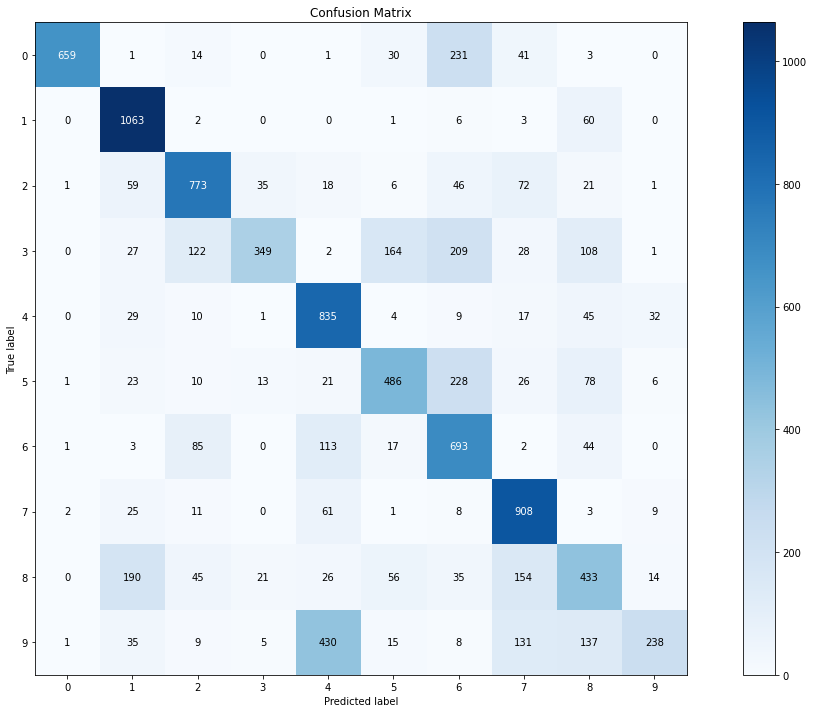

In [14]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test_true_labels, 
    y_test_pred_labels,
    figsize=(20,12))

# Conclusion

Have attained accuracy of 64.37% on augmented 

# Part B : Using Keras

In [18]:
from keras import models
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.datasets import mnist
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from keras.optimizers import Adam
%matplotlib inline

# Utilizing Adapting learning rate (Adam)

Have used Adaptive Moment Estimation (Adam)  to update network weights iteratively. Have chosen ADAM because it includes the advantages of two other extensions - AdaGrad and RMSProp.

In [19]:

opt = Adam()


# Loading and Printing dimensions

In [20]:
Num_of_Rows = 28
Num_of_Cols = 28
Num_of_Labels = 10
BATCH_SIZE = 128
EPOCHS = 10

def data_size(X_train, y_train, X_test, y_test):
    """Summarize current state of dataset"""
    print('Training images shape:', X_train.shape)
    print('Training labels shape:', y_train.shape)
    print('Validation images shape:', X_test.shape)
    print('Validation labels shape:', y_test.shape)



"""Load and prepare data"""

# Load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Check state of dataset
data_size(X_train, y_train, X_test, y_test)



Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Validation images shape: (10000, 28, 28)
Validation labels shape: (10000,)


# Reshaping and encoding labels

In [21]:
# Reshape data
X_train = X_train.reshape((X_train.shape[0], Num_of_Rows * Num_of_Cols))
X_train = X_train.astype('float32') / 255
X_test = X_test.reshape((X_test.shape[0], Num_of_Rows * Num_of_Cols))
X_test = X_test.astype('float32') / 255

# Categorically encode labels
y_train = to_categorical(y_train, Num_of_Labels)
y_test = to_categorical(y_test, Num_of_Labels)




#Training on original Dataset

In [22]:
"""Build and train neural network"""

# Build neural network
model = models.Sequential()
model.add(Dense(512, activation='relu', input_shape=(Num_of_Rows * Num_of_Cols,)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, activation='softmax'))

# Compile model
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train model
model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          validation_data=(X_test, y_test))



Epoch 1/10
469/469 [==============================] - 8s 16ms/step - loss: 0.6556 - accuracy: 0.7910 - val_loss: 0.1267 - val_accuracy: 0.9624
Epoch 2/10
469/469 [==============================] - 7s 15ms/step - loss: 0.1800 - accuracy: 0.9458 - val_loss: 0.0998 - val_accuracy: 0.9694
Epoch 3/10
469/469 [==============================] - 6s 13ms/step - loss: 0.1359 - accuracy: 0.9590 - val_loss: 0.0894 - val_accuracy: 0.9732
Epoch 4/10
469/469 [==============================] - 6s 13ms/step - loss: 0.1130 - accuracy: 0.9658 - val_loss: 0.0722 - val_accuracy: 0.9782
Epoch 5/10
469/469 [==============================] - 6s 13ms/step - loss: 0.1015 - accuracy: 0.9681 - val_loss: 0.0682 - val_accuracy: 0.9780
Epoch 6/10
469/469 [==============================] - 6s 13ms/step - loss: 0.0868 - accuracy: 0.9726 - val_loss: 0.0661 - val_accuracy: 0.9795
Epoch 7/10
469/469 [==============================] - 6s 13ms/step - loss: 0.0817 - accuracy: 0.9745 - val_loss: 0.0675 - val_accuracy: 0.9792

# Model Evaluation on original Dataset

In [23]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


"""Summarize and visualize the model"""

# Summary of neural network
model.summary()

Test loss: 0.06376983970403671
Test accuracy: 0.9824000000953674
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_______________________________________________________

# Traning on Augmented Dataset

In [26]:
# Load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Reshape data
X_train = X_train.reshape((X_train.shape[0], Num_of_Rows * Num_of_Cols))
X_train = X_train.astype('float32') / 255
X_test = X_test.reshape((X_test.shape[0], Num_of_Rows * Num_of_Cols))
X_test = X_test.astype('float32') / 255

# Categorically encode labels
y_train = to_categorical(y_train, Num_of_Labels)
y_test = to_categorical(y_test, Num_of_Labels)




In [29]:
X_augmented=X_train_aug.reshape(x_train.shape[0],28*28)
print(X_augmented.shape)

(60000, 784)


In [31]:
"""Build and train neural network"""

# Build neural network
model = models.Sequential()
model.add(Dense(512, activation='relu', input_shape=(Num_of_Rows * Num_of_Cols,)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, activation='softmax'))

# Compile model
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train model
model.fit(X_augmented, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          validation_data=(X_test, y_test))



Epoch 1/10
469/469 [==============================] - 7s 14ms/step - loss: 20.3596 - accuracy: 0.3463 - val_loss: 2.3043 - val_accuracy: 0.0974
Epoch 2/10
469/469 [==============================] - 6s 13ms/step - loss: 1.0958 - accuracy: 0.6458 - val_loss: 2.4048 - val_accuracy: 0.0974
Epoch 3/10
469/469 [==============================] - 6s 14ms/step - loss: 0.9121 - accuracy: 0.7115 - val_loss: 2.4844 - val_accuracy: 0.0974
Epoch 4/10
469/469 [==============================] - 7s 14ms/step - loss: 0.8415 - accuracy: 0.7382 - val_loss: 2.5310 - val_accuracy: 0.0974
Epoch 5/10
469/469 [==============================] - 6s 13ms/step - loss: 0.7805 - accuracy: 0.7635 - val_loss: 2.5854 - val_accuracy: 0.0974
Epoch 6/10
469/469 [==============================] - 6s 13ms/step - loss: 0.7412 - accuracy: 0.7787 - val_loss: 2.6380 - val_accuracy: 0.0974
Epoch 7/10
469/469 [==============================] - 7s 14ms/step - loss: 0.7002 - accuracy: 0.7913 - val_loss: 2.6333 - val_accuracy: 0.097

# Model Evaluation on Augmented Dataset

In [32]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


"""Summarize and visualize the model"""

# Summary of neural network
model.summary()

Test loss: 2.7071774005889893
Test accuracy: 0.09740000218153
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_19 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
__________________________________________________________